# Introduction:
In this notebook, I will be analyzing user data from Last.fm.  Last.fm is a site for users to share their music with their friends and it connects to your music player service to track what and who you are listening to.  This notebook contains three parts:


**1. ETL with SQLite3:**
* In this section I extract the Last.fm data from the relevant files and load it into a database.

**2. Network Analysis with Unweighted Centrality:**
* In this section I use degree centrality to identify the most influential users based on the number of friends they have.

**3. Weighted Centrality Measures:**
* In this section I refine the measurement from part 2 based on the assumption that not all connections are equal.  I use eigenvector centrality which identifies influential users based on the number of friends they have and the weight of each connection.

# Part 1: ETL with SQLite3

In [1]:
import os
import pandas as pd
import math
import latex
import matplotlib.pyplot as plt
import sqlite3
import plotly.plotly as py
from plotly.graph_objs import *
import numpy as np
import networkx as nx
import scipy.sparse as sparse
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## Loading data from Last.fm

Includes:


**1. A table** `artists` **with variables:**
* `id` (primary key):    the artist id.
* `name`:     the artist name.
* `url`:     link to the artist's Last.fm page.
* `pictureURL`:     picture of artist.
    
**2. A table** `users` **with variables:**
* `userID` (primary key):     the user id.
* `artistID` (foreign key to `artists`):    the artist id.
* `weight`:     the number of minutes spent listening to that artistID. 

**3. A table** `user friends` **with variables:**
* `userID` (foreign key to `users`):     the user id.
* `friendID` (primary key):     the friend id.
    

Using this data, let's first load it into a proper SQL database and then see if we can identify the most 'influential' listeners.

In [2]:
#read .dat files into pandas dataframes
artists = pd.read_csv('/data/artists.dat',sep='\t')
users = pd.read_csv('/data/user_artists.dat',sep='\t')
user_friends = pd.read_csv('/data/user_friends.dat',sep='\t')

In [3]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [4]:
users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [5]:
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


## Creating DB with SQLite

Use SQLite3 to create a database

In [6]:
def create_connection(db):
    try:
        conn = sqlite3.connect(db)
        return conn
    except ValueError:
        print('Database already in current directory.')
    
    return None

def create_table(connection, table, name):
    table.to_sql("{}".format(name),connection,index=False)
        
def main():
    db = 'artist_user.db'
    conn = create_connection(db)
    try:
        create_table(conn,artists,'artists')
        create_table(conn,users,'users')
        create_table(conn,user_friends,'friends')
    except ValueError:
        print("The tables have already been created.")

In [7]:
if __name__ == '__main__':
    main()

Checking to make sure all tables were properly loaded into my database:

In [8]:
conn = create_connection('artist_user.db')
cursor = conn.cursor()
cursor.execute("select name from sqlite_master where type='table';")
print(cursor.fetchall())

[('artists',), ('users',), ('friends',)]


# Part 2: Network Analysis with Unweighted Centrality:

After loading our data into the database, we can query it to do some basic analysis as well as gather the necessary data for our network analysis.  In this part, I'll be analyzing the network using a measure called degree centrality in which influence is a function of how many friends a user has.  In a graph each user is treated as a vertex and each connection an edge between vertices.

In [9]:
#create dataframe from table friends
friend_query = """select
            userID
            , friendID
            from friends;"""

df_friends = pd.read_sql_query(friend_query,conn)
df_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


Next I need to create an adjacency dictionary such that each user is a key and each friend of theirs is a value:

In [10]:
#convert each row of the dataframe into a tuple.
observations = list(zip(df_friends.userID,df_friends.friendID))

#create dictionary and load tuples as key-value pairs.
userLinks = {}
for (userID, friendID) in observations:
    if not userID in userLinks.keys():
        userLinks[userID] = []
    userLinks[userID].append(friendID)

#aggregate all friends for each user.
friends = set([friendID for (userID,friendID) in observations])

#load aggregate into second dictionary.
friendLinks = { friendID : set() for friendID in friends}

for friendList in userLinks.values():
    for friend in friendList:
        friendLinks[friend] = friendLinks[friend].union(set(friendList))

Then I convert the adjacency dictionary to an adjacency matrix using pandas and numpy:

In [11]:
edges = [(userID,friendID) for userID,friendIDs in friendLinks.items() for friendID in friendIDs]

df = pd.DataFrame(edges)

adj_mat = np.matrix(pd.crosstab(df[0],df[1]))
print(adj_mat) 

[[1 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 1 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 1 0 0]
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]]


Create graph using networkx package:

In [12]:
G=nx.from_numpy_matrix(adj_mat)

In [13]:
degree = nx.degree_centrality(G)

Let's load a DataFrame containing the two columns `userID` and `influence` into our database.  `influence` is measured by degree centrality where the more connections a user has, the greater their "influence."

In [14]:
user_influence=pd.DataFrame.from_dict(degree,orient='index')
user_influence['userID'] = user_influence.index
user_influence.columns = ['influence', 'userID']
create_table(conn,user_influence,'user_influence')

In [15]:
sorted_users = [x for x in degree.items()] 

sorted_users.sort(key=lambda x: x[1],reverse=True)
print(sorted_users[0:5])

[(772, 0.5668958223162348), (1394, 0.508725542041248), (1164, 0.4843997884717081), (1710, 0.47170809095716554), (137, 0.4706504494976203)]


**Takeaways:** As expected, user with userID 772 had the greatest number of friends and is also considered the most influential by degree centrality.  Degree centrality is quite a simple measurement as it treats each connection equally, later I'll weight the connections to obtain a more refined measurement of influence.

In [16]:
#look at the top artists of the top 5 users
x1=','.join(str(x[0]) for x in sorted_users[0:5])
pwr_artists = """select
            a.userID
            , a.weight as minutes_listened
            , b.name
            , b.url
         from users a
         left join artists b
             on a.artistID = b.id
         where a.userID in ({top5users})"""
pwr_artists=pwr_artists.format(top5users=x1)
artistWeights = pd.read_sql_query(pwr_artists,conn)
artistWeights.head()

,userID,minutes_listened,name,url
0,137,1108,Kylie Minogue,http://www.last.fm/music/Kylie+Minogue
1,137,1512,Daft Punk,http://www.last.fm/music/Daft+Punk
2,137,1569,Goldfrapp,http://www.last.fm/music/Goldfrapp
3,137,409,Röyksopp,http://www.last.fm/music/R%C3%B6yksopp
4,137,536,Coldplay,http://www.last.fm/music/Coldplay


How does time spent listening to Last.fm relate to the number of friends a user has?  Would one expect there to be a positive or negative correlation between the two?  I would hypothesize that the more one listens the more friends they would have, since time listening is a great proxy for engagement with the site.


To explore, one can plot user influence as determined by degree centrality against the total time listening for each user.  Influence as defined above is a direct approximation for the number of friends a user has, so the plot will allow us to see the correlation between number of friends and time listening.  

The best fitting equation is: 
           2
1.151e-12 x - 2.766e-07 x + 0.1197


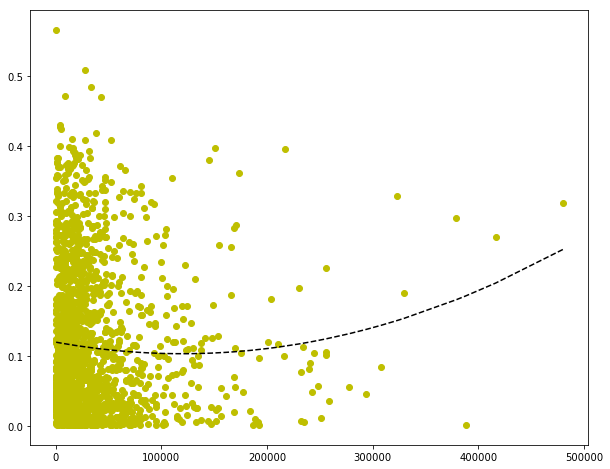

In [17]:
time_listening = """select
            a.userID
            , a.influence
            , sum(b.weight) as minutes_listened
         from user_influence a
         inner join users b
             on a.userID = b.userID
         group by a.userID, a.influence
         order by sum(b.weight) desc;"""

#create dataframe
influence_vs_listening = pd.read_sql_query(time_listening,conn)

#fit polynomial
fit = np.polyfit(influence_vs_listening['minutes_listened'],influence_vs_listening['influence'],2)
fit_fn = np.poly1d(fit) 
print("The best fitting equation is: \n{}".format(fit_fn))



plt.plot(influence_vs_listening['minutes_listened'], influence_vs_listening['influence'],'yo',influence_vs_listening['minutes_listened'],fit_fn(influence_vs_listening['minutes_listened']),'--k')
plt.show() 

**Takeaways:** It appears from visual inspection as though there is a slight negative correlation between time listening and influence.  If one fits a quadratic polynomial to the data we see that it is initially decreasing before increasing.  Based on the sparsity of data points on the upper end of the time listening distribution, I suspect the upward inflection is due to outliers and the true trend is negative.

# Part 3: Weighted Centrality Measures
In addition to being a great proxy for engagement, the amount of time a user spends listening directly affects the number of opportunities they have to influence one of their friends.  

Where I initially assumed all users had equal influence (i.e. weight = 1), in reality some connections must be more 'valuable' than others. So now I can perform a similar centrality analysis with the weights:
$$\sum t_{i,j}$$

where $t_i$ represents the amount of time user $i$ spends cumulatively listening.

Specifically we will be using eigenvector centrality.

In [18]:
#query to select user x, user y, and the weight along the edge
weightedQuery = """select
                a.userID
                , b.friendID
                , sum(a.weight) + sum(c.weight) as weight
                from users a
                inner join friends b
                    on a.userID = b.userID
                inner join users c
                    on b.friendID = c.userID
                group by a.userID, b.friendID;"""
weightedUsers = np.array(pd.read_sql_query(weightedQuery,conn))
print(weightedUsers)

[[       2      275  8554650]
 [       2      428 18619100]
 [       2      515  8947550]
 ..., 
 [    2099     2016   671250]
 [    2100      586  2134800]
 [    2100      607  2183600]]


Create weighted adjacency matrix using numpy and scipy:

In [19]:
shape = tuple(weightedUsers.max(axis=0)[:2]+1)
#create sparse matrix
coo = sparse.coo_matrix((weightedUsers[:,2], (weightedUsers[:,0], weightedUsers[:,1])), shape=shape,
                        dtype=weightedUsers.dtype)

print(coo)

  (2, 275)	8554650
  (2, 428)	18619100
  (2, 515)	8947550
  (2, 761)	10150950
  (2, 831)	14053350
  (2, 909)	14408150
  (2, 1209)	8674000
  (2, 1210)	23137650
  (2, 1230)	8463050
  (2, 1327)	8479000
  (2, 1585)	15657000
  (2, 1625)	8458000
  (2, 1869)	9788700
  (3, 78)	1561050
  (3, 255)	1957050
  (3, 460)	1945300
  (3, 837)	1684600
  (3, 1740)	3957850
  (3, 1801)	1150750
  (3, 1975)	2110900
  (4, 99)	2137250
  (4, 124)	2933300
  (4, 211)	3094650
  (4, 264)	3679050
  (4, 493)	1340640
  :	:
  (2091, 1948)	761950
  (2091, 1950)	1559650
  (2092, 1295)	3667800
  (2092, 2084)	4202950
  (2093, 157)	793000
  (2093, 1266)	30396
  (2093, 1731)	22382
  (2093, 1914)	1790650
  (2094, 1628)	8672100
  (2094, 1816)	5844850
  (2095, 655)	277700
  (2095, 1342)	3952500
  (2096, 1787)	4116850
  (2097, 31)	2093200
  (2097, 172)	1642950
  (2097, 1173)	2843550
  (2097, 1343)	752550
  (2097, 1642)	20104050
  (2097, 1785)	5426150
  (2099, 1507)	595100
  (2099, 1801)	634650
  (2099, 2006)	2292950
  (2099, 2016

As before each of the vertices of the graph will be a user and each edge will be a connection between users.  The difference is that now each edge additionally has a weight, which is the cumulative time spent listening by both connected users.

In [20]:
#gather sparse matrix and convert to graph
weightedAdj = coo.todense()
print(weightedAdj)

wG=nx.from_numpy_matrix(weightedAdj)
eigenV = nx.eigenvector_centrality(wG)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [21]:
#find the top 5 users by influence
sorted_users = [x for x in eigenV.items()] 

sorted_users.sort(key=lambda x: x[1],reverse=True)
print(sorted_users[0:5])

[(514, 0.2745078764197715), (621, 0.20666147941200141), (1300, 0.18094748186268877), (851, 0.16718895811666853), (385, 0.1625755535567184)]


**Takeaways:** Using eigenvector centrality, one identifies an entirely different set of influential users.  Clearly, the number of friends a user has is not the sole predictor of influence.  None of the top 100 most influential users as identified by degree centrality overlap with the top 100 users as identified by eigenvector centrality.  This is perhaps not surprising as the chart above suggests that, if anything, there is a small negative correlation between the number of friends a user has and the amount of time they spend listening to music.

**Conclusion:** Measures of centrality are useful in a wide variety of scenarios that involve connections between objects of interest.  For example, as a research assistant in the School of International Political Affairs at Columbia University at 2015, I used degree centrality to analyze New York State labor union data.  The goal was to identify union members who had donated to a union fund and could potentially influence other union members in their area to donate.  The centrality measure is consequently composed of both the number of members in the same local union as the member in question (the edges) and the amount each member has donated (the weights).  My analysis allowed the labor union in question to target highly influential members with messaging, thereby providing potential revenue at a lower cost.

## Index: Extra Graphs

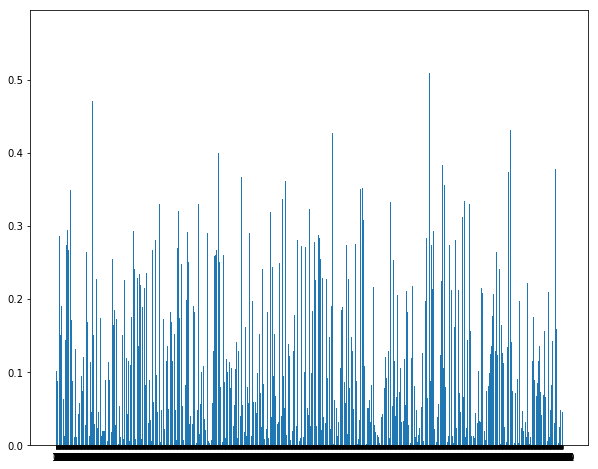

In [22]:
#plot users and their relative influence
plt.bar(range(len(degree)),degree.values(),align='center')
plt.xticks(range(len(degree)), list(degree.keys()))
plt.show()

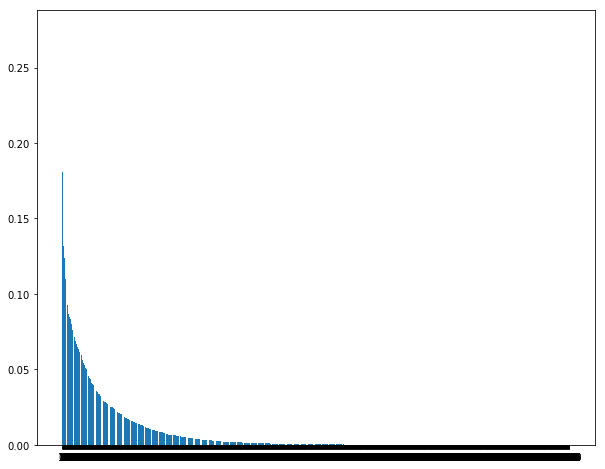

In [23]:
#histogram of influence
freq = [x[1] for x in sorted_users]
plt.bar(range(len(freq)),freq,align='center')
plt.xticks(range(len(freq)))
plt.show()